In [1]:
from berny import Berny, geomlib, coords,Geometry,Math
from pyscf import gto,scf
import numpy as np 
from numpy.linalg import norm as norm
import matplotlib.pyplot as plt
from pyscf.grad import rhf as grhf
from pyscf.hessian import rhf as hrhf
import basis_set_exchange as bse
from pyscf.geomopt.berny_solver import optimize
from scipy.interpolate import spline
ang2bohr=1.8897261246
bohr2ang=.5291772109
hartree2kcal=627.509
uffbde=100/hartree2kcal
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append( '/home/administrator/Documenti/APDFT/prototyping/hessian/AAFF/Libs')
from aaff import aaff,alc_deriv_grad_nuc,alc_differential_grad_nuc
from Morse import Morse_interpolator,harm_freq,mpa
from FDcoeffs import *
from FcMole import FcM,FcM_like
from AP_class import APDFT_perturbator
from ABSE import absec

In [3]:
import pyscf.data
import pandas as pd

In [4]:
def bernyopt(name,mol):
    geom=Geometry([name[0],name[1]],mol.atom_coords()*bohr2ang)
    return Berny(geom)

In [5]:
def appHess(name,mol):
    return bernyopt(name,mol)._state.H[0,0]

In [6]:
co_min=(2.08272, -112.78661621869807)
nn_min=(2.01389, -108.98906407528155)
bf_min=(2.35348, -124.16243198073053)
pcx2=bse.get_basis("pcX-2",fmt="nwchem",elements=[5,6,7,8,9])

In [7]:
CO=gto.M(atom="C 0 0 0; O 0 0 2.08272",unit="Bohr",basis=pcx2)
NN=gto.M(atom="N 0 0 0; N 0 0 2.01389",unit="Bohr",basis=pcx2)
BF=gto.M(atom="B 0 0 0; F 0 0 2.35348",unit="Bohr",basis=pcx2)

In [8]:
COhf=scf.RHF(CO)
NNhf=scf.RHF(NN)
BFhf=scf.RHF(BF)
COhf.scf()
NNhf.scf()
BFhf.scf()

converged SCF energy = -112.786616218695
converged SCF energy = -108.989064075281
converged SCF energy = -124.162431980725


-124.16243198072524

In [9]:
#dm01=COhf.make_rdm1()
COscanpts=np.linspace(1.8,2.6,31)
#COscan=[]
#for x in COscanpts:
#    mol=gto.M(atom="C 0 0 0; O 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
#    mf=scf.RHF(mol)
#    COscan.append(mf.scf(dm0=dm01))
#    dm01=mf.make_rdm1()

In [10]:
#dm01=BFhf.make_rdm1()
BFscanpts=np.linspace(2.,2.8,31)
#BFscan=[]
#for x in BFscanpts:
#    mol=gto.M(atom="B 0 0 0; F 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
#    mf=scf.RHF(mol)
#    BFscan.append(mf.scf(dm0=dm01))
#    dm01=mf.make_rdm1()

In [11]:
#dm01=NNhf.make_rdm1()
NNscanpts=np.linspace(1.7,2.4,31)
#NNscan=[]
#for x in NNscanpts:
#    mol=gto.M(atom="N 0 0 0; N 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
#    mf=scf.RHF(mol)
#    NNscan.append(mf.scf(dm0=dm01))
#    dm01=mf.make_rdm1()

In [12]:
#np.save("scandiatomics",np.asarray([NNscan,COscan,BFscan]))
NNscan,COscan,BFscan=np.load("scandiatomics.npy")

In [13]:
def e_scan(mol,pt):
    if mol=="CO": return spline(COscanpts,COscan,pt)
    if mol=="BF": return spline(BFscanpts,BFscan,pt)
    if mol=="NN": return spline(NNscanpts,NNscan,pt)

In [14]:
spline(COscanpts,COscan,2.3)

/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  """Entry point for launching an IPython kernel.


array(-112.75844033)

In [15]:
bde={"bf":uffbde,\
    "co_bf":uffbde*3,\
    "co_nn":uffbde*3,\
    "nn":uffbde*3,\
}

In [16]:
# derivatives of the gradient and the hessian from af and FD
dl=0.1
c5=get_coeffs(5)
def hoad(mol):
    afs=[]
    hs=[]
    for i in range(-2,3):
        mol1=FcM_like(mol,fcs=[i*dl,-i*dl])
        mf=scf.RHF(mol1)
        mf.scf(dm0=mf.init_guess_by_1e())
        afs.append(aaff(mf,[1,-1])[1,2])
        hs.append(mf.Hessian().hess()[1,1,2,2])
    gders=[afs[2],c5[1].dot(afs)/dl,c5[2].dot(afs)/dl**2,c5[3].dot(afs)/dl**3,c5[4].dot(afs)/dl**4]
    hders=[hs[2],c5[1].dot(hs)/dl,c5[2].dot(hs)/dl**2,c5[3].dot(hs)/dl**3,c5[4].dot(hs)/dl**4]
    return np.asarray(gders),np.asarray(hders)

In [17]:
def ep(mol,dz):
    dz=np.asarray(dz)
    eps=[]
    ad=[]
    mf=scf.RHF(mol)
    mf.scf(dm0=mf.init_guess_by_1e())
    ap=APDFT_perturbator(mf,sites=[0,1])
    ap.build_all()
    eps.append(ap.APDFT1(dz))
    eps.append(ap.APDFT2(dz))
    eps.append(ap.APDFT3(dz))
    ad.append(np.einsum("ijk,i,j,k",ap.cubic_hessian,dz,dz,dz))
    for i in [-1,1]:
        mol1=FcM_like(mol,fcs=[i*dl,-i*dl])
        mf=scf.RHF(mol1)
        mf.scf(dm0=mf.init_guess_by_1e())
        ap=APDFT_perturbator(mf,sites=[0,1])
        ap.build_all()
        ad.append(np.einsum("ijk,i,j,k",ap.cubic_hessian,dz,dz,dz))
    eps.append(eps[-1]+(ad[2]-ad[1])/2/dl/24)
    eps.append(eps[-1]+(ad[2]+ad[1]-2*ad[0])/dl**2/120)
    return np.asarray(eps)

In [18]:
#epco_nn=ep(CO,[1,-1])
#epco_bf=ep(CO,[-1,1])
#epbf_co=ep(BF,[1,-1])
#epnn_co=ep(NN,[1,-1])
epnn_bf=ep(NN,[2,-2])
epbf_nn=ep(BF,[2,-2])

converged SCF energy = -108.989064075282


/home/administrator/anaconda3/lib/python3.7/site-packages/pyscf/gto/mole.py:1072: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -109.02699241248
converged SCF energy = -109.02699241248
converged SCF energy = -124.162431980726
converged SCF energy = -125.71407409587
converged SCF energy = -122.68467322445


In [19]:
epbf_nn

array([ -93.86773845, -108.64435069, -108.91767756, -108.92943773,
       -108.92678521])

In [20]:
#mol1=FcM_like(CO,fcs=[1,-1])
#mf=scf.RHF(mol1)
#mf.scf(dm0=mf.init_guess_by_1e())

In [21]:
#gderCO,hderCO=hoad(CO)
#gderBF,hderBF=hoad(BF)
#gderNN,hderNN=hoad(NN)
#np.save("./Diatomics_derivs",np.asarray([gderCO,hderCO,gderBF,hderBF,gderNN,hderNN]))

In [22]:
#gderCO=np.load("./Diatomics_derivs.npy")[0]
#hderCO=np.load("./Diatomics_derivs.npy")[1]
#gderBF=np.load("./Diatomics_derivs.npy")[2]
#hderBF=np.load("./Diatomics_derivs.npy")[3]
#gderNN=np.load("./Diatomics_derivs.npy")[4]
#hderNN=np.load("./Diatomics_derivs.npy")[5]

In [23]:
#gpco_nn=[gderCO[0]+alc_deriv_grad_nuc(CO,[1,-1])[1,2],
#        gderCO[0]+gderCO[1]/2+alc_differential_grad_nuc(CO,[1,-1])[1,2],
#         gderCO[0]+gderCO[1]/2+gderCO[2]/6+alc_differential_grad_nuc(CO,[1,-1])[1,2],
#        gderCO[0]+gderCO[1]/2+gderCO[2]/6+gderCO[3]/24+alc_differential_grad_nuc(CO,[1,-1])[1,2],
#        gderCO[0]+gderCO[1]/2+gderCO[2]/6+gderCO[3]/24+gderCO[4]/120+alc_differential_grad_nuc(CO,[1,-1])[1,2]]

In [24]:
#hpco_nn=[hderCO[0],
#         hderCO[0]+hderCO[1],
#         hderCO[0]+hderCO[1]+hderCO[2]/2,
#         hderCO[0]+hderCO[1]+hderCO[2]/2+hderCO[3]/6,
#         hderCO[0]+hderCO[1]+hderCO[2]/2+hderCO[3]/6+hderCO[4]/24]

In [26]:
#gpco_bf=[-gderCO[0]+alc_deriv_grad_nuc(CO,[-1,1])[1,2],
#    -gderCO[0]+gderCO[1]/2+alc_differential_grad_nuc(CO,[-1,1])[1,2],
#    -gderCO[0]+gderCO[1]/2-gderCO[2]/6+alc_differential_grad_nuc(CO,[-1,1])[1,2],
#    -gderCO[0]+gderCO[1]/2-gderCO[2]/6+gderCO[3]/24+alc_differential_grad_nuc(CO,[-1,1])[1,2],
#    -gderCO[0]+gderCO[1]/2-gderCO[2]/6+gderCO[3]/24-gderCO[4]/120+alc_differential_grad_nuc(CO,[-1,1])[1,2]]

In [27]:
#hpco_bf=[hderCO[0],
#         hderCO[0]-hderCO[1],
#         hderCO[0]-hderCO[1]+hderCO[2]/2,
#         hderCO[0]-hderCO[1]+hderCO[2]/2-hderCO[3]/6,
#         hderCO[0]-hderCO[1]+hderCO[2]/2-hderCO[3]/6+hderCO[4]/24]

In [28]:
#gpbf_co=[gderBF[0]+alc_deriv_grad_nuc(BF,[1,-1])[1,2],
#         gderBF[0]+gderBF[1]/2+alc_differential_grad_nuc(BF,[1,-1])[1,2],
#         gderBF[0]+gderBF[1]/2+gderBF[2]/6+alc_differential_grad_nuc(BF,[1,-1])[1,2],
#         gderBF[0]+gderBF[1]/2+gderBF[2]/6+gderBF[3]/24+alc_differential_grad_nuc(BF,[1,-1])[1,2],
#         gderBF[0]+gderBF[1]/2+gderBF[2]/6+gderBF[3]/24+gderBF[4]/120+alc_differential_grad_nuc(BF,[1,-1])[1,2]]

In [29]:
#hpbf_co=[hderBF[0],
#         hderBF[0]+hderBF[1],
#         hderBF[0]+hderBF[1]+hderBF[2]/2,
#         hderBF[0]+hderBF[1]+hderBF[2]/2+hderBF[3]/6,
#         hderBF[0]+hderBF[1]+hderBF[2]/2+hderBF[3]/6+hderBF[4]/24]

In [30]:
#gpbf_nn=[gderBF[0]*2+alc_deriv_grad_nuc(BF,[2,-2])[1,2],
#         gderBF[0]*2+gderBF[1]/2*4+alc_differential_grad_nuc(BF,[2,-2])[1,2],
#         gderBF[0]*2+gderBF[1]/2*4+gderBF[2]/6*8+alc_differential_grad_nuc(BF,[2,-2])[1,2],
#         gderBF[0]*2+gderBF[1]/2*4+gderBF[2]/6*8+gderBF[3]/24*16+alc_differential_grad_nuc(BF,[2,-2])[1,2],
#         gderBF[0]*2+gderBF[1]/2*4+gderBF[2]/6*8+gderBF[3]/24*16+gderBF[4]/120*32+alc_differential_grad_nuc(BF,[2,-2])[1,2]]

In [31]:
#hpbf_nn=[hderBF[0],
#         hderBF[0]+hderBF[1]*2,
#         hderBF[0]+hderBF[1]*2+hderBF[2]/2*4,
#         hderBF[0]+hderBF[1]*2+hderBF[2]/2*4+hderBF[3]/6*8,
#         hderBF[0]+hderBF[1]*2+hderBF[2]/2*4+hderBF[3]/6*8+hderBF[4]/24*16]

In [33]:
#gpnn_co=[gderNN[0]+alc_deriv_grad_nuc(NN,[1,-1])[1,2],
#         gderNN[0]+gderNN[1]/2+alc_differential_grad_nuc(NN,[1,-1])[1,2],
#         gderNN[0]+gderNN[1]/2+gderNN[2]/6+alc_differential_grad_nuc(NN,[1,-1])[1,2],
#         gderNN[0]+gderNN[1]/2+gderNN[2]/6+gderNN[3]/24+alc_differential_grad_nuc(NN,[1,-1])[1,2],
#         gderNN[0]+gderNN[1]/2+gderNN[2]/6+gderNN[3]/24+gderNN[4]/120+alc_differential_grad_nuc(NN,[1,-1])[1,2]]

In [34]:
#hpnn_co=[hderNN[0],
#         hderNN[0]+hderNN[1],
#         hderNN[0]+hderNN[1]+hderNN[2]/2,
#         hderNN[0]+hderNN[1]+hderNN[2]/2+hderNN[3]/6,
#         hderNN[0]+hderNN[1]+hderNN[2]/2+hderNN[3]/6+hderNN[4]/24]

In [35]:
#gpnn_bf=[gderNN[0]*2+alc_deriv_grad_nuc(NN,[2,-2])[1,2],
#         gderNN[0]*2+gderNN[1]/2*4+alc_differential_grad_nuc(NN,[2,-2])[1,2],
#         gderNN[0]*2+gderNN[1]/2*4+gderNN[2]/6*8+alc_differential_grad_nuc(NN,[2,-2])[1,2],
#         gderNN[0]*2+gderNN[1]/2*4+gderNN[2]/6*8+gderNN[3]/24*16+alc_differential_grad_nuc(NN,[2,-2])[1,2],
#         gderNN[0]*2+gderNN[1]/2*4+gderNN[2]/6*8+gderNN[3]/24*16+gderNN[4]/120*32+alc_differential_grad_nuc(NN,[2,-2])[1,2]]

In [36]:
#hpnn_bf=[hderNN[0],
#         hderNN[0]+hderNN[1]*2,
#         hderNN[0]+hderNN[1]*2+hderNN[2]/2*4,
#         hderNN[0]+hderNN[1]*2+hderNN[2]/2*4+hderNN[3]/6*8,
#         hderNN[0]+hderNN[1]*2+hderNN[2]/2*4+hderNN[3]/6*8+hderNN[4]/24*16]

In [68]:
def quad_app(e,g,h,m,an):
    print(np.round( e-g**2/h/2,decimals=4),np.round(m[0]-g/h,decimals=3),\
               int(np.round(harm_freq(h,*an),decimals=0)))

-109.0494 1.761 1490


In [75]:
#np.save("predictionsdiatomics",np.asarray([epbf_co,gpbf_co,hpbf_co,epco_nn,gpco_nn,hpco_nn,\
#epco_bf,gpco_bf,hpco_bf,epnn_co,gpnn_co,hpnn_co,epbf_nn,gpbf_nn,hpbf_nn,epnn_bf,gpnn_bf,hpnn_bf]))

In [76]:
predictions=np.load("predictionsdiatomics.npy")
epbf_co=predictions[0]
gpbf_co=predictions[1]
hpbf_co=predictions[2]
epco_nn=predictions[3]
gpco_nn=predictions[4]
hpco_nn=predictions[5]
epco_bf=predictions[6]
gpco_bf=predictions[7]
hpco_bf=predictions[8]
epnn_co=predictions[9]
gpnn_co=predictions[10]
hpnn_co=predictions[11]
epbf_nn=predictions[12]
gpbf_nn=predictions[13]
hpbf_nn=predictions[14]
epnn_bf=predictions[15]
gpnn_bf=predictions[16]
pnn_bf=predictions[17]

In [65]:
for i in range(1,4):
    print("APDFT{}".format(i+1))
    mi = Morse_interpolator(gpnn_bf[i],hpnn_bf[i+1],nn_min[0],bde["bf"],epnn_bf[i+1])
    print(mi.minimum(),mi.hfd(5,9))
    mi = Morse_interpolator(gpbf_nn[i],hpbf_nn[i+1],bf_min[0],bde["nn"],epbf_nn[i+1])
    print(mi.minimum(),mi.hfd(7,7))

APDFT2
(2.5432926253791646, -124.29038482116263) 1233.2132826018285
(2.132758402823305, -109.03200764643422) 5081.557282537594
APDFT3
(2.543292626619875, -124.25131293737606) 1233.2132807021903
(2.0844411785730887, -109.02205576998445) 3509.75961660511
APDFT4
(2.3691758223964188, -124.20328369912444) 1440.164890361898
(2.109845072968124, -108.99833001421781) 3130.369657869566


In [73]:
for i in range(1,4):
    print("APDFT{}".format(i+1))
    quad_app(epnn_bf[i+1],gpnn_bf[i],hpnn_bf[i+1],nn_min,[5,9])
for i in range(1,4):
    print("APDFT{}".format(i+1))
    quad_app(epbf_nn[i+1],gpbf_nn[i],hpbf_nn[i+1],bf_min,[7,7])


APDFT2
-124.2586 2.29 2676
APDFT3
-124.2195 2.29 2676
APDFT4
-124.1884 2.221 2678
APDFT2
-109.4238 0.813 1244
APDFT3
-109.1547 1.375 1274
APDFT4
-109.0494 1.761 1490


In [58]:
#for i in range(len(epco_bf)):
#    epco_bf[i]+=absec("CO","BF")
#for i in range(len(epbf_co)):
#    epbf_co[i]+=absec("BF","CO")
#for i in range(len(epco_nn)):
#    epco_nn[i]+=absec("CO","NN")
#for i in range(len(epnn_co)):
#    epnn_co[i]+=absec("NN","CO")
#for i in range(len(epnn_bf)):
#    epnn_bf[i]+=absec("NN","BF")
#for i in range(len(epbf_nn)):
#    epbf_nn[i]+=absec("BF","NN")

/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  
/home/administrator/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  after removing the cwd from sys.path.


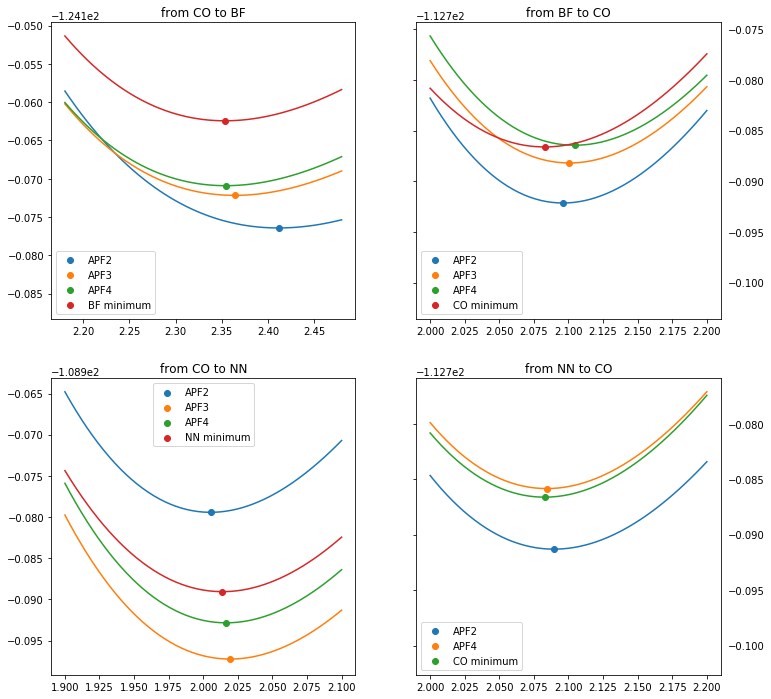

In [45]:
fig, ((ax1, ax2), (ax3, ax4)) =plt.subplots(2,2,figsize=(12,12))
lss=["--",":",]
ax1.set_title("from CO to BF")
scan=np.linspace(2.18,2.48,51)
for i in range(1,4):
    mi = Morse_interpolator(gpco_bf[i],hpco_bf[i+1],co_min[0],bde["bf"],epco_bf[i+1])
    ax1.scatter(*mi.minimum(),label="APF{}".format(i+1))
    ax1.plot(scan,mi.E(scan))
ax1.scatter(*bf_min,label="BF minimum")
ax1.plot(scan,e_scan("BF",scan))
ax1.legend()
#ax1.set_xlim(2.25,2.4)
#ax1.set_ylim(ax1.get_ylim()[0]+0.009,ax1.get_ylim()[1]-0.008)
#print(dir(ax1))
#############################
ax2.set_title("from BF to CO")
ax2.yaxis.set_tick_params(labelleft=False,labelright=True)
scan=np.linspace(2.0,2.2,51)
for i in range(1,4):
    mi = Morse_interpolator(gpbf_co[i],hpbf_co[i+1],bf_min[0],bde["co_bf"],epbf_co[i+1])
    ax2.scatter(*mi.minimum(),label="APF{}".format(i+1))
    ax2.plot(scan,mi.E(scan))
ax2.scatter(*co_min,label="CO minimum")
ax2.plot(scan,e_scan("CO",scan))
ax2.legend() 
###############################
ax3.set_title("from CO to NN")
scan=np.linspace(1.9,2.1,51)
for i in range(1,4):
    mi = Morse_interpolator(gpco_nn[i],hpco_nn[i+1],co_min[0],bde["nn"],epco_nn[i])
    ax3.scatter(*mi.minimum(),label="APF{}".format(i+1))
    ax3.plot(scan,mi.E(scan))
ax3.scatter(*nn_min,label="NN minimum")
ax3.plot(scan,e_scan("NN",scan))
ax3.legend() 
##############################
ax4.set_title("from NN to CO")
ax4.yaxis.set_tick_params(labelleft=False,labelright=True)
scan=np.linspace(2.0,2.2,51)
for i in [1,3]:
    mi = Morse_interpolator(gpnn_co[i],hpnn_co[i+1],nn_min[0],bde["co_nn"],epnn_co[i])
    ax4.scatter(*mi.minimum(),label="APF{}".format(i+1))
    ax4.plot(scan,mi.E(scan))
ax4.scatter(*co_min,label="CO minimum")
ax4.plot(scan,e_scan("CO",scan))
ax4.legend()
#plt.savefig("diatomics.png",bbox_inches="tight")

In [46]:
epnn_co

array([-108.99376457, -112.78664718, -112.78664718, -112.78176319,
       -112.78176319])

In [47]:
co_min

(2.08272, -112.78661621869807)

In [48]:
thf=scf.RHF(FcM_like(NN,fcs=[1,-1]))
thf.scf(dm0=thf.init_guess_by_1e())

converged SCF energy = -112.777015615484


-112.77701561548446

In [49]:
scanpts2=np.linspace(1.7,2.8,31)
#NNscan2=[]
#COscan2=[]
#BFscan2=[]
#for x in scanpts2:
#    mol=gto.M(atom="N 0 0 0; N 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
#    mf=scf.RHF(mol)
#    NNscan2.append(mf.scf())
#    mol=gto.M(atom="C 0 0 0; O 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
#    mf=scf.RHF(mol)
#    COscan2.append(mf.scf())
#    mol=gto.M(atom="B 0 0 0; F 0 0 {}".format(x),unit="Bohr",basis=pcx2,verbose=0)
#    mf=scf.RHF(mol)
#    BFscan2.append(mf.scf())
#np.save("scan2diatomics",np.asarray([NNscan2,COscan2,BFscan2]))

In [50]:
NNscan2,COscan2,BFscan2=np.load("scan2diatomics.npy")

1453.4636273636343 2406.9746499572184 1506.5153811794694
2588.813677949486 1418.0780489521078 2429.508265705918
2784.7954000771915 2411.4181301563694 2730.3566784452223
morse 2388.524522361522 NR 2739.6691755747547 target 2429.508265705918


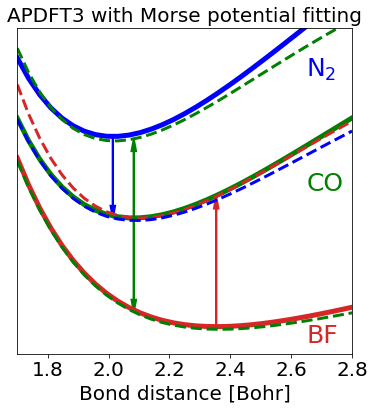

In [51]:
plt.figure(figsize=(6,6))
plt.plot(scanpts2,np.asarray(NNscan2)-min(NNscan2),lw=5,color="blue")
plt.plot(scanpts2,np.asarray(COscan2)-min(COscan2)-.15,lw=5,color="green")
plt.plot(scanpts2,np.asarray(BFscan2)-min(BFscan2)-.35,lw=5,color="C3")

i=2
#co->bf
mi = Morse_interpolator(gpco_bf[i],hpco_bf[i+1],co_min[0],bde["bf"]\
                        ,epco_bf[i]-min(BFscan2)-.35)
print(mi.hfd(5,9),harm_freq(hpco_bf[i+1],5,9),harm_freq(hderBF[0],5,9))
plt.plot(scanpts2,mi.E(scanpts2),ls="--",lw=3,color="green")

#bf->co
mi = Morse_interpolator(gpbf_co[i],hpbf_co[i+1],bf_min[0],bde["co_bf"],\
                        epbf_co[i]-min(COscan2)-.15)
plt.plot(scanpts2,mi.E(scanpts2),ls="--",lw=3,color="C3")
print(mi.hfd(6,8),harm_freq(hpbf_co[i+1],6,8),harm_freq(hderCO[0],6,8))

#  co->nn
mi = Morse_interpolator(gpco_nn[i],hpco_nn[i+1],co_min[0],bde["nn"],\
                        epco_nn[i]-min(NNscan2))
plt.plot(scanpts2,mi.E(scanpts2),ls="--",lw=3,color="green")
print(mi.hfd(7,7),harm_freq(hpco_nn[i+1],7,7),harm_freq(hderNN[0],7,7))

# nn->co
mi = Morse_interpolator(gpnn_co[i],hpnn_co[i+1],nn_min[0],bde["co_nn"],\
                        epnn_co[i]-min(COscan2)-.15)
plt.plot(scanpts2,mi.E(scanpts2),ls="--",lw=3,color="blue")
print("morse",mi.hfd(6,8),"NR",harm_freq(hpnn_co[i+1],6,8),"target",harm_freq(hderCO[0],6,8))

plt.arrow(co_min[0],-.15,0,epco_bf[i]-min(BFscan2)-.2 ,length_includes_head=True,\
          color="green",lw=2,head_width=.015)
plt.arrow(co_min[0],-.15,0,epco_nn[i]-min(NNscan2)+.15 ,length_includes_head=True,\
          color="green",lw=2,head_width=.015)
plt.arrow(nn_min[0],0.,0,epnn_co[i]-min(COscan2)-.15 ,length_includes_head=True,\
          color="blue",lw=2,head_width=.015)
plt.arrow(bf_min[0],-.35,0,epbf_co[i]-min(COscan2)+.2 ,length_includes_head=True,\
          color="C3",lw=2,head_width=.015)

plt.xlim(1.7,2.8)
plt.ylim(-0.4,0.2)
plt.text(2.65,0.11,"N$_2$",size=25,color="blue")
plt.text(2.65,-.1,"CO",size=25,color="green")
plt.text(2.65,-.38,"BF",size=25,color="C3")
plt.yticks([])
plt.xticks(size=20)
plt.xlabel("Bond distance [Bohr]",size=20)
plt.title("APDFT3 with Morse potential fitting",size=20)
plt.savefig("diatomics_scheme.png",bbox_inc="Tight")

In [52]:
[epbf_co,gpbf_co,hpbf_co,epco_nn,gpco_nn,hpco_nn,epco_bf,gpco_bf,hpco_bf,epnn_co,gpnn_co,hpnn_co]

[array([-109.0184803 , -112.71263336, -112.74679921, -112.74826923,
        -112.74793767]),
 array([0.26677747, 0.29137599, 0.26499772, 0.26048561, 0.25940357]),
 array([0.59158882, 0.53805323, 0.51945098, 0.5219488 , 0.53185219]),
 array([-105.20021073, -108.97344318, -108.9934959 , -108.98869125,
        -108.98823242]),
 array([0.22455568, 0.14553084, 0.11321999, 0.11968826, 0.12152897]),
 array([1.53201985, 1.55370336, 1.54712035, 1.54073842, 1.54492391]),
 array([-120.38228151, -124.15551397, -124.13546124, -124.1402659 ,
        -124.14072472]),
 array([-0.22455568, -0.30358052, -0.27126967, -0.2648014 , -0.26664211]),
 array([1.53201985, 1.51033635, 1.50375334, 1.51013527, 1.51432075]),
 array([-108.99376457, -112.78664718, -112.78664718, -112.78176319,
        -112.78176319]),
 array([-2.86320479e-13, -1.29057851e-01, -1.29057851e-01, -1.21040505e-01,
        -1.21040505e-01]),
 array([1.97525258, 1.97525258, 1.94815667, 1.94815667, 1.94830662])]

In [53]:
len(predictions)

12

In [54]:
q=[]
#co->bf

for i in [1,2,3]:
    mi = Morse_interpolator(gpco_bf[i],hpco_bf[i+1],co_min[0],bde["bf"],epco_bf[i])
    q.append({"Molecule" :"CO $\rightarrow$ BF APDFT{}".format(i+1),"energy minimum": np.round(mi.minimum()[1],decimals=4),\
             "distance minimum": np.round(mi.minimum()[0],decimals=3),"harm freq":int(np.round(mi.hfd(5,9),decimals=0))} )
q.append({"Molecule" :"true BF","energy minimum": np.round(bf_min[1],decimals=4),"distance minimum": \
          np.round(bf_min[0],decimals=3),"harm freq":int(np.round(harm_freq(hderBF[0],6,8),decimals=0))} )

#bf->co
for i in [1,2,3]:
    mi = Morse_interpolator(gpbf_co[i],hpbf_co[i+1],bf_min[0],bde["co_bf"],epbf_co[i])
    q.append({"Molecule" :"BF $\rightarrow$ CO APDFT{}".format(i+1),"energy minimum": np.round(mi.minimum()[1],decimals=4),\
             "distance minimum": np.round(mi.minimum()[0],decimals=3),"harm freq":int(np.round(mi.hfd(6,8),decimals=0))} )
# nn->co
for i in [1,3]:
    mi = Morse_interpolator(gpnn_co[i],hpnn_co[i+1],nn_min[0],bde["co_nn"],epnn_co[i])
    q.append({"Molecule" :"N$_2$ $\rightarrow$ CO APDFT{}".format(i+1),"energy minimum": np.round(mi.minimum()[1],decimals=4),\
             "distance minimum": np.round(mi.minimum()[0],decimals=3),"harm freq":int(np.round(mi.hfd(6,8),decimals=0))})
q.append({"Molecule" :"true CO","energy minimum": np.round(co_min[1],decimals=4),"distance minimum": \
          np.round(co_min[0],decimals=3),"harm freq":int(np.round(harm_freq(hderCO[0],6,8),decimals=0))} )

#  co->nn
for i in [1,2,3]:
    mi = Morse_interpolator(gpco_nn[i],hpco_nn[i+1],co_min[0],bde["nn"],epco_nn[i])
    q.append({"Molecule" :"CO $\rightarrow$ N$_2$ APDFT{}".format(i+1),"energy minimum": np.round(mi.minimum()[1],decimals=4),\
             "distance minimum": np.round(mi.minimum()[0],decimals=3),"harm freq":int(np.round(mi.hfd(7,7),decimals=0))})
q.append({"Molecule" :"true N$_2$","energy minimum": np.round(nn_min[1],decimals=4),"distance minimum": \
          np.round(nn_min[0],decimals=3),"harm freq":int(np.round(harm_freq(hderNN[0],6,8),decimals=0))} )


In [55]:
pd.DataFrame(q)
print(pd.DataFrame(q).to_latex())

\begin{tabular}{llrrr}
\toprule
{} &                       Molecule &  distance minimum &  energy minimum &  harm freq \\
\midrule
0  &     CO \$\textbackslash rightarrow\$ BF APDFT2 &             2.412 &       -124.1965 &       1379 \\
1  &     CO \$\textbackslash rightarrow\$ BF APDFT3 &             2.364 &       -124.1674 &       1453 \\
2  &     CO \$\textbackslash rightarrow\$ BF APDFT4 &             2.354 &       -124.1704 &       1471 \\
3  &                        true BF &             2.353 &       -124.1624 &       1510 \\
4  &     BF \$\textbackslash rightarrow\$ CO APDFT2 &             2.096 &       -112.7580 &       2744 \\
5  &     BF \$\textbackslash rightarrow\$ CO APDFT3 &             2.101 &       -112.7867 &       2589 \\
6  &     BF \$\textbackslash rightarrow\$ CO APDFT4 &             2.104 &       -112.7868 &       2572 \\
7  &  N\$\_2\$ \$\textbackslash rightarrow\$ CO APDFT2 &             2.090 &       -112.7913 &       2389 \\
8  &  N\$\_2\$ \$\textbackslash ri

In [56]:
q2=[]
#co->bf
for i in [1,2,3]:
    mi = Morse_interpolator(gpco_bf[i],hpco_bf[i+1],co_min[0],bde["bf"],epco_bf[i])
    q2.append({"Molecule" :"CO $\rightarrow$ BF APDFT{}".format(i+1),\
                "energy minimum": np.round( epco_bf[i]-gpco_bf[i]**2/hpco_bf[i+1]/2,decimals=4),\
             "distance minimum": np.round(co_min[0]-gpco_bf[i]/hpco_bf[i+1],decimals=3),\
               "harm freq":int(np.round(harm_freq(hpco_bf[i+1],7,7),decimals=0))})
q2.append({"Molecule" :"true BF","energy minimum": np.round(bf_min[1],decimals=4),"distance minimum": \
          np.round(bf_min[0],decimals=3),"harm freq":int(np.round(harm_freq(hderBF[0],6,8),decimals=0))} )
    

#bf->co
for i in [1,2,3]:
    q2.append({"Molecule" :"BF $\rightarrow$ CO APDFT{}".format(i+1),
               "energy minimum": np.round( epbf_co[i]-gpbf_co[i]**2/hpbf_co[i+1]/2,decimals=4),\
             "distance minimum": np.round(bf_min[0]-gpbf_co[i]/hpbf_co[i+1],decimals=3),\
               "harm freq":int(np.round(harm_freq(hpbf_co[i+1],7,7),decimals=0))})
# nn->co
for i in [1,3]:
    q2.append({"Molecule" :"N$_2$ $\rightarrow$ CO APDFT{}".format(i+1),\
               "energy minimum": np.round( epnn_co[i]-gpnn_co[i]**2/hpnn_co[i+1]/2,decimals=4),\
             "distance minimum": np.round(nn_min[0]-gpnn_co[i]/hpnn_co[i+1],decimals=3),\
               "harm freq":int(np.round(harm_freq(hpnn_co[i+1],7,7),decimals=0))})
q2.append({"Molecule" :"true CO","energy minimum": np.round(co_min[1],decimals=4),"distance minimum": \
          np.round(co_min[0],decimals=3),"harm freq":int(np.round(harm_freq(hderCO[0],6,8),decimals=0))} )


#  co->nn
for i in [1,2,3]:
    q2.append({"Molecule" :"CO $\rightarrow$ N$_2$ APDFT{}".format(i+1),\
               "energy minimum": np.round( epco_nn[i]-gpco_nn[i]**2/hpco_nn[i+1]/2,decimals=4),\
             "distance minimum": np.round(co_min[0]-gpco_nn[i]/hpco_nn[i+1],decimals=3),\
               "harm freq":int(np.round(harm_freq(hpco_nn[i+1],7,7),decimals=0))})
q2.append({"Molecule" :"true N$_2$","energy minimum": np.round(nn_min[1],decimals=4),"distance minimum": \
          np.round(nn_min[0],decimals=3),"harm freq":int(np.round(harm_freq(hderNN[0],6,8),decimals=0))} )

In [57]:
print(pd.DataFrame(q2).to_latex())

\begin{tabular}{llrrr}
\toprule
{} &                       Molecule &  distance minimum &  energy minimum &  harm freq \\
\midrule
0  &     CO \$\textbackslash rightarrow\$ BF APDFT2 &             2.285 &       -124.1862 &       2382 \\
1  &     CO \$\textbackslash rightarrow\$ BF APDFT3 &             2.262 &       -124.1598 &       2387 \\
2  &     CO \$\textbackslash rightarrow\$ BF APDFT4 &             2.258 &       -124.1634 &       2391 \\
3  &                        true BF &             2.353 &       -124.1624 &       1510 \\
4  &     BF \$\textbackslash rightarrow\$ CO APDFT2 &             1.793 &       -112.7944 &       1400 \\
5  &     BF \$\textbackslash rightarrow\$ CO APDFT3 &             1.846 &       -112.8141 &       1404 \\
6  &     BF \$\textbackslash rightarrow\$ CO APDFT4 &             1.864 &       -112.8121 &       1417 \\
7  &  N\$\_2\$ \$\textbackslash rightarrow\$ CO APDFT2 &             2.080 &       -112.7909 &       2712 \\
8  &  N\$\_2\$ \$\textbackslash ri